### Readme

* Reduced units are used:
* $\begin{aligned} \xi = \big(\frac{m K}{\hbar^2}\big)^{1/4}x \end{aligned}$
* 
* $\begin{aligned} \varepsilon = \frac{E}{\hbar\omega} \end{aligned}$
* 
* xmax : $[0,x_{max}]$ the farest position to be integrated.
* nodes: The number of nodes of wave function $\psi(x)$.
* mesh:  The number of integration grid, $N_{grid}$.

* dx:    $\delta{x}$
* ddx12: $\begin{aligned}\frac{(\delta x)^2}{12}\end{aligned}$

In [1]:
import numpy as np
import sys,os

In [28]:


### Reduced units are used.
### x = (mK/hbar^2)^(1/4) X
### e = E/(hbar omega)

xmax  = 4.5
nodes = 1
mesh  = 200
eps   = 1.0E-10
fileout = 'output.dat'

x    = np.zeros((mesh+1))
y    = np.zeros((mesh+1))
p    = np.zeros((mesh+1))
vpot = np.zeros((mesh+1))
f    = np.zeros((mesh+1))

dx   =  xmax/mesh 
ddx12=dx*dx/12.0E0

for i in range(mesh+1): ### i runs from 0 to mesh
    x[i]    = np.float(i)*dx
    ### Generate the potential energy on all grids at once:
    vpot[i] = 0.5E0*x[i]**2 

if (fileout != ''):
    ff = open(fileout,'w')

if nodes<0 :
    print ("noes must be larger than 0!")
    sys.exit()

eup = np.max(vpot)
elw = np.min(vpot)

e   = 0.0E0

if ( np.abs(e) < eps):
    e      = 0.5E0*(elw+eup)
    n_iter = 1000
else:
    n_iter = 1 ### test a single energy value
    
for kkk in range(n_iter):
    f[0] = ddx12*(2.0E0*(vpot[0]-e)) 
    icl = -1
    for i in range(1, mesh+1):
        f[i] = ddx12*2.0E0*(vpot[i]-e)
        if np.abs(f[i])< 1.0E-20:
            f[i] = 1.0E-20
        if (i>1) and np.sign(f[i])!= np.sign(f[i-1]): ### Measuring the sign changing of the wave function.
            ### This means the potential energy becomes larger than total energy.
            icl = i
    ### End do i
    if (icl>= mesh -2 ):
        print("Last change of sign too far")
        sys.exit()
    elif (icl<1):
        print("No classical turning point?")
        sys.exit()
    f = np.subtract(1.0E0,f) ## fn(x) = 1+2(e-V(x))(dx)^2/12
    hnodes = np.int(nodes/2)
    if nodes%2 == 0:
        y[0]   = 1.0E0
        y[1]   = 0.5E0*(12.0E0-10.0E0*f[0])*y[0]/f[1]
    else:
        y[0]   = 0.0E0
        y[1]   = dx ## Theoretically, y_1 can be an arbitary small number.
    ### End if here
    
    ### Outward integration, and count the number of crossings.
    ncross = 0
    for i in range(1, icl,1):
        y[i+1]=((12.0E0-10.0E0*f[i])*y[i] - f[i-1]*y[i-1])/f[i+1]
        if np.sign(y[i]) != np.sign(y[i+1]):
            ncross += 1
    fac = y[icl]
    
    ### Here the forward integration is finished. One can output it.
    
    ###
    
    if (nodes%2==0):
        ## Even nodes: no node in x=0
        ncross = 2*ncross
    else:
        ## Odd nodes: node in x=0
        ncross = 2*ncross + 1
    
    ### Check the number of crossings.
    
    if (n_iter > 1):
        if (ncross != nodes):
            ### Incorect number of crossings: adjust energy
            if (kkk == 1):
                print ("Bisection         Energy       Nodes  Discontinuity")
                print ("%5d %25.15f  %5d" % (kkk, e, ncross))
            if (ncross > nodes):
                eup = e
            else:
                elw = e
            e = 0.5E0*(eup+elw)
            continue
        ### end if (ncross != nodes)
    else:
        print("%12.6f %5d %5d" % (e, ncross, nodes))
    ### End if (n_iter > 1)
    ###
    ### Correct number of crossings: backward integration.
    ###
    y[mesh] = dx
    y[mesh-1] = (12.0E0-10.0E0*f[mesh])*y[mesh]/f[mesh-1]
    for i in range(mesh-1,icl,-1):
        y[i-1]= ((12.0E0-10.0E0*f[i])*y[i]-f[i+1]*y[i+1])/f[i-1]
    ###
    ### Rescale function to match at the classical turning point.
    ###
    fac = fac/y[icl]
    y[icl:] = y[icl:]*fac
    ### 
    ### Normalize on the [-xmax, xmax] segment
    ### The x = 0 point must be conted once
    ###
    norm = (2.0E0*np.dot(y,y)- y[0]*y[0]) * dx
    y = y/ np.sqrt(norm)

    if (n_iter > 1):
        djump = (y[icl+1] +y[icl-1] - (14.0E0-12.0E0*f[icl])*y[icl])/dx
    print('%5d %25.15f %5d %14.8f' % (kkk, e, nodes, djump))
    if (djump*y[icl] > 0.0E0):
        eup = e
    else:
        elw = e
    e = 0.5E0 *(eup + elw)
    if (eup - elw < 1.0E-10):
        break
### End the iteration.
### Calculation of the classical probability density for e:
### P = \sum_k m / |p_k| 
### H(q, p_k) = e
### p_k = \sqrt{ 2m (e - V)}
###
norm = 0.0E0
for i in range(icl+1):
    arg = (e- x[i]**2/2.0E0)
    if (arg > 0.0E0):
        p[i] = 1.0E0/np.sqrt(arg)
    else:
        p[i] = 0.0E0
    norm = norm + 2.0E0 *dx*p[i]
### End for
norm = norm - dx*p[i]
p[:icl] = p[:icl]/norm
ff.write("#   x       y(x)         y(x)^2         classical p(x)      V\n")
### x<0 region
for i in range(mesh, 0, -1): ### i runs over [mesh,1]
    line_str = "{:7.3f}{:16.8e}{:16.8e}{:16.8e}{:12.6f}\n".format(-x[i],(-1)**nodes*y[i],y[i]**2,p[i],vpot[i])
    ff.write(line_str)
### x>0 region
for i in range(0,mesh+1,1):
    line_str = "{:7.3f}{:16.8e}{:16.8e}{:16.8e}{:12.6f}\n".format(x[i],y[i],y[i]**2,p[i],vpot[i])
    ff.write(line_str)  
ff.write('\n')
ff.close()

Bisection         Energy       Nodes  Discontinuity
    1         2.531250000000000      3
    2         1.265625000000000     1    -0.49189519
    4         1.582031250000000     1     0.21633404
    5         1.423828125000000     1    -0.17629715
    6         1.502929687500000     1     0.00732755
    7         1.463378906250000     1    -0.08922756
    8         1.483154296875000     1    -0.04105557
    9         1.493041992187500     1    -0.01696033
   10         1.497985839843750     1    -0.00491170
   11         1.500457763671875     1     0.00111269
   12         1.499221801757812     1    -0.00189951
   13         1.499839782714844     1    -0.00039341
   14         1.500148773193359     1     0.00035964
   15         1.499994277954102     1    -0.00001688
   16         1.500071525573730     1     0.00017138
   17         1.500032901763916     1     0.00007725
   18         1.500013589859009     1     0.00003018
   19         1.500003933906555     1     0.00000665
   20   

In [29]:
a = np.genfromtxt('output.dat')
print(np.shape(a))

(401, 5)


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt


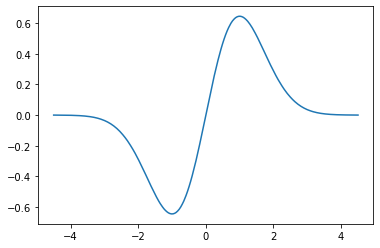

In [32]:
plt.plot(a[:,0],a[:,1],'-')
plt.show()

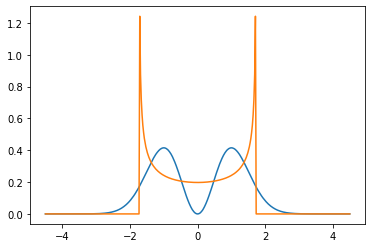

In [33]:
plt.plot(a[:,0],a[:,2],'-')
plt.plot(a[:,0],a[:,3],'-')
plt.show()

## Bellow are tests.

In [2]:
np.sign((1.0,-1.0))

array([ 1., -1.])

In [5]:
print(np.sign(4.0))
print(np.sign(-5.0))


1.0
-1.0


In [9]:
print(np.int(3/2))

1


In [11]:
for i in range(10):
    if i==5:
        continue
    print("%5d" % (i))
    

    0
    1
    2
    3
    4
    6
    7
    8
    9


In [16]:
line_str = '{:8.3f}{:16.8e}\n'.format(1.2,1.0E+5)
print (line_str)
print ("END")

   1.200  1.00000000e+05

END
